In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:

!pip install yellowbrick

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3 -> 23.1.2
[notice] To update, run: /usr/bin/python3 -m pip install --upgrade pip


In [28]:

import os
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import matplotlib as mpl
import numpy as np
from yellowbrick.cluster import KElbowVisualizer
from datetime import time,timedelta,datetime,date
import pickle



import os
currentFile=os.path.abspath(os.getcwd())
print(currentFile)
inten=currentFile.split('PatronesComportamiento-Notebooks/')







/home/ana/Documentos/TFG/PatronesComportamiento/Notebooks/PatronesComportamiento-Notebooks/PatronesComportamiento


Para poder hacer el clustering primero habrá que extraer los dataframe de cada uno de los ficheros que contienen las series temporales.
También dividiremos los datos en entrenamiento y test. Algo que debemos tener en cuenta a la hora de hacer esta división es que nuestro objeto de estudio son series temporales, por tanto, debemos plantear una for de dividir los datos sin que afecte a la línea temporal de los mismos. (Explicar con detalle cuando lea información al respecto).


Para que la división utilizada respete la cronología se utilizará el método: [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html#sklearn.model_selection.TimeSeriesSplit) de la librería SK Learn. Este método permite aplicar validación cruzada a series temporales respectando la cronología, Para este método, si k es el número de pliegues devolverá el pliegue k como el último conjunto que formará parte del conjunto de entrenamiento y el k+1 como el primero del conjunto de test. A diferencia de los métodos cotidianos de validación cruzada, los conjuntos sucesivos de entrenamiento son superconjuntos de los conjuntos de entrenamiento previos. Con este método obtendremos los índices de los conjuntos que formarán parte del entrenamiento y de los que formarán parte del test.


In [45]:
directory = str(inten[0])+'intensOcupation'

mySeries = []
namesofMySeries = []
counter=0
dataframes_list=[]
singleSerie=[]
cont=0
for filename in os.listdir(directory):

    if filename.endswith(".csv") and filename!='datAxes.csv' :
      df = pd.read_csv(directory+"/"+filename)
      df = df.loc[:,["intensidad"]]  #cojo la columna indicada
     
      
      dim=len(df.to_numpy()) #calculamos la longitud del dataframe

  
      check=list(df.to_numpy().reshape(dim)[:287])
      for a in check:
        
        if math.isnan(a):
            print(filename)
            cont+=1

      mySeries.append(check)  #conseguimos una lista que hemos redimensionado a 1 dimensión y hemos hecho que tenga longitud 287
      singleSerie.extend(list(df.to_numpy().reshape(dim)[:287]))
      if dim<287:
        print(filename+' '+ str(dim))
      
      
      




      namesofMySeries.append(filename)
      counter+=1
ninety=int(len(singleSerie)*0.9)
train=singleSerie[:ninety]
valit=singleSerie[ninety:]
print(len(mySeries))

with open(str(currentFile)+'/singleSerieIntenTrT.pkl', 'wb') as file:
        pickle.dump(train, file)

with open(str(currentFile)+'/singleSerieIntenValit.pkl', 'wb') as file:
        pickle.dump(valit, file)

with open(str(currentFile)+'/mySeriesInten.pkl', 'wb') as file:
        pickle.dump(mySeries, file)

with open(str(currentFile)+'/singleSerieInten.pkl', 'wb') as file:
        pickle.dump(singleSerie, file)

print("contador"+str(cont))
print(len(mySeries[0]))

683
contador0
287


Ahora hacemos el clustering, k es el número de clústers que vamos a querer utilizar.

In [46]:
import math
k=3
kmeans = KMeans(n_clusters=k, random_state=50)
for i in mySeries:
    for a in i:
        if math.isnan(a):
            print(a)
y_pred = kmeans.fit(mySeries).predict(mySeries)



Distancias al centro del clúster, como vemos en la celda superior y_pred da un array con el cluster al que pertenece cada serie según la posición que ocupa, es decir, si el primer elemento del array es un 2 quiere decir que la primera series pertenece al clúster 2. Además, con kmeans.cluster_centers_ podemos conseguir las coordenadas de cada centro.

In [47]:
dias_senalar=[]

for m in range(len(mySeries)):
  #para cada serie
  y=kmeans.cluster_centers_[y_pred[m]]; #sacar las coordenadas del cluster de la serie en posición m
  dist = np.sqrt(np.sum([(a-b)*(a-b) for a, b in zip(mySeries[m], y)]))
  if dist >70:
    dias_senalar.append(m)

    #Descomentar las líneas de abajo para ver que distancias a al centroide de series anómalas.
    
    #print("Cluster "+ str(y_pred[m]))

    #print("Distancia euclídea entre serie "+ str(m) + ' '+ namesofMySeries[m]+" y clúster " +str(y_pred[m])+":", dist)


Vamos a representar las series temporales en sus clústers, en azul se visualiza el centroide y el verde aquellas series que pese haber sido asignadas a ese clúster presentan una gran distancia al centroide de su clúster.

In [50]:

directory = str(inten[0])+'/intensOcupation'
def plot_data():
    for m in mySeries:
        plt.plot(m, color='r',)  #represenamos todas las series


def plot_centroids():
    fig, axs = plt.subplots(k,1,figsize=(25,25))  #creamos k subplots



    for m in range(len(mySeries)):

     
      axs[y_pred[m]].plot(mySeries[m],color='r')  #en rojo representamos la serie m en el cluster correspondiente

      axs[y_pred[m]].title.set_text("Clúster " + str(y_pred[m]+1))
      axs[y_pred[m]].title.set_fontsize(30)

    for m in range(len(kmeans.cluster_centers_)):
        axs[m].plot(kmeans.cluster_centers_[m], color='b',linewidth=3)  #ahora representamos el centroide
        df = pd.read_csv(directory+"/datAxes.csv")  #para poner el tiempo en el eje nos valemos de una serie que tiene columnas tiempo y valor
        df = df.loc[:,["time", "value"]]
        df = df.dropna()  # elimina las filas con valores nulos

        # Calcular los índices equitativos
        indices = [i for i in range(0, len(df), len(df)//10)]  #geneamos los índices equiespaciados en 10 partes

        # Establecer los valores de xticks
        xticks = [df.iloc[i]['time'] for i in indices]  #etiquetas

        axs[m].plot(df['time'], df['value'], alpha=0)
        axs[m].set_xticks(xticks)


        axs[m].set_ylabel('Intensidad',fontsize=18)
        axs[m].set_xlabel('Doceavos',fontsize=18)


    '''
    for m in dias_senalar:
        axs[y_pred[m]].plot(mySeries[m],color='g',linewidth=3)  #en verde representamos la serie m que presenta anomalía

    '''


      



A cotinuación se representan todas las series en la primera gráfica y en la siguientes, k (recuerda, k es el número de clústers, por tanto, si es igual a 3 pues, 3 gráficas siguientes).

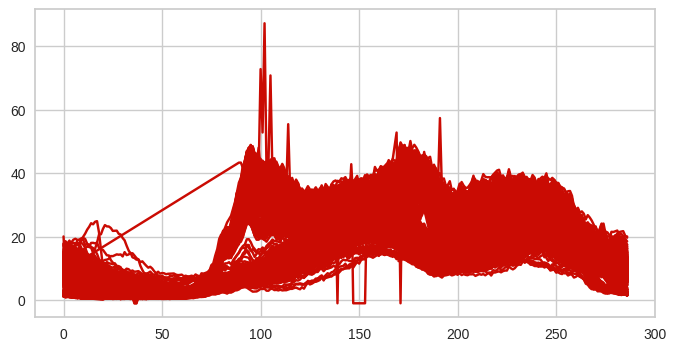

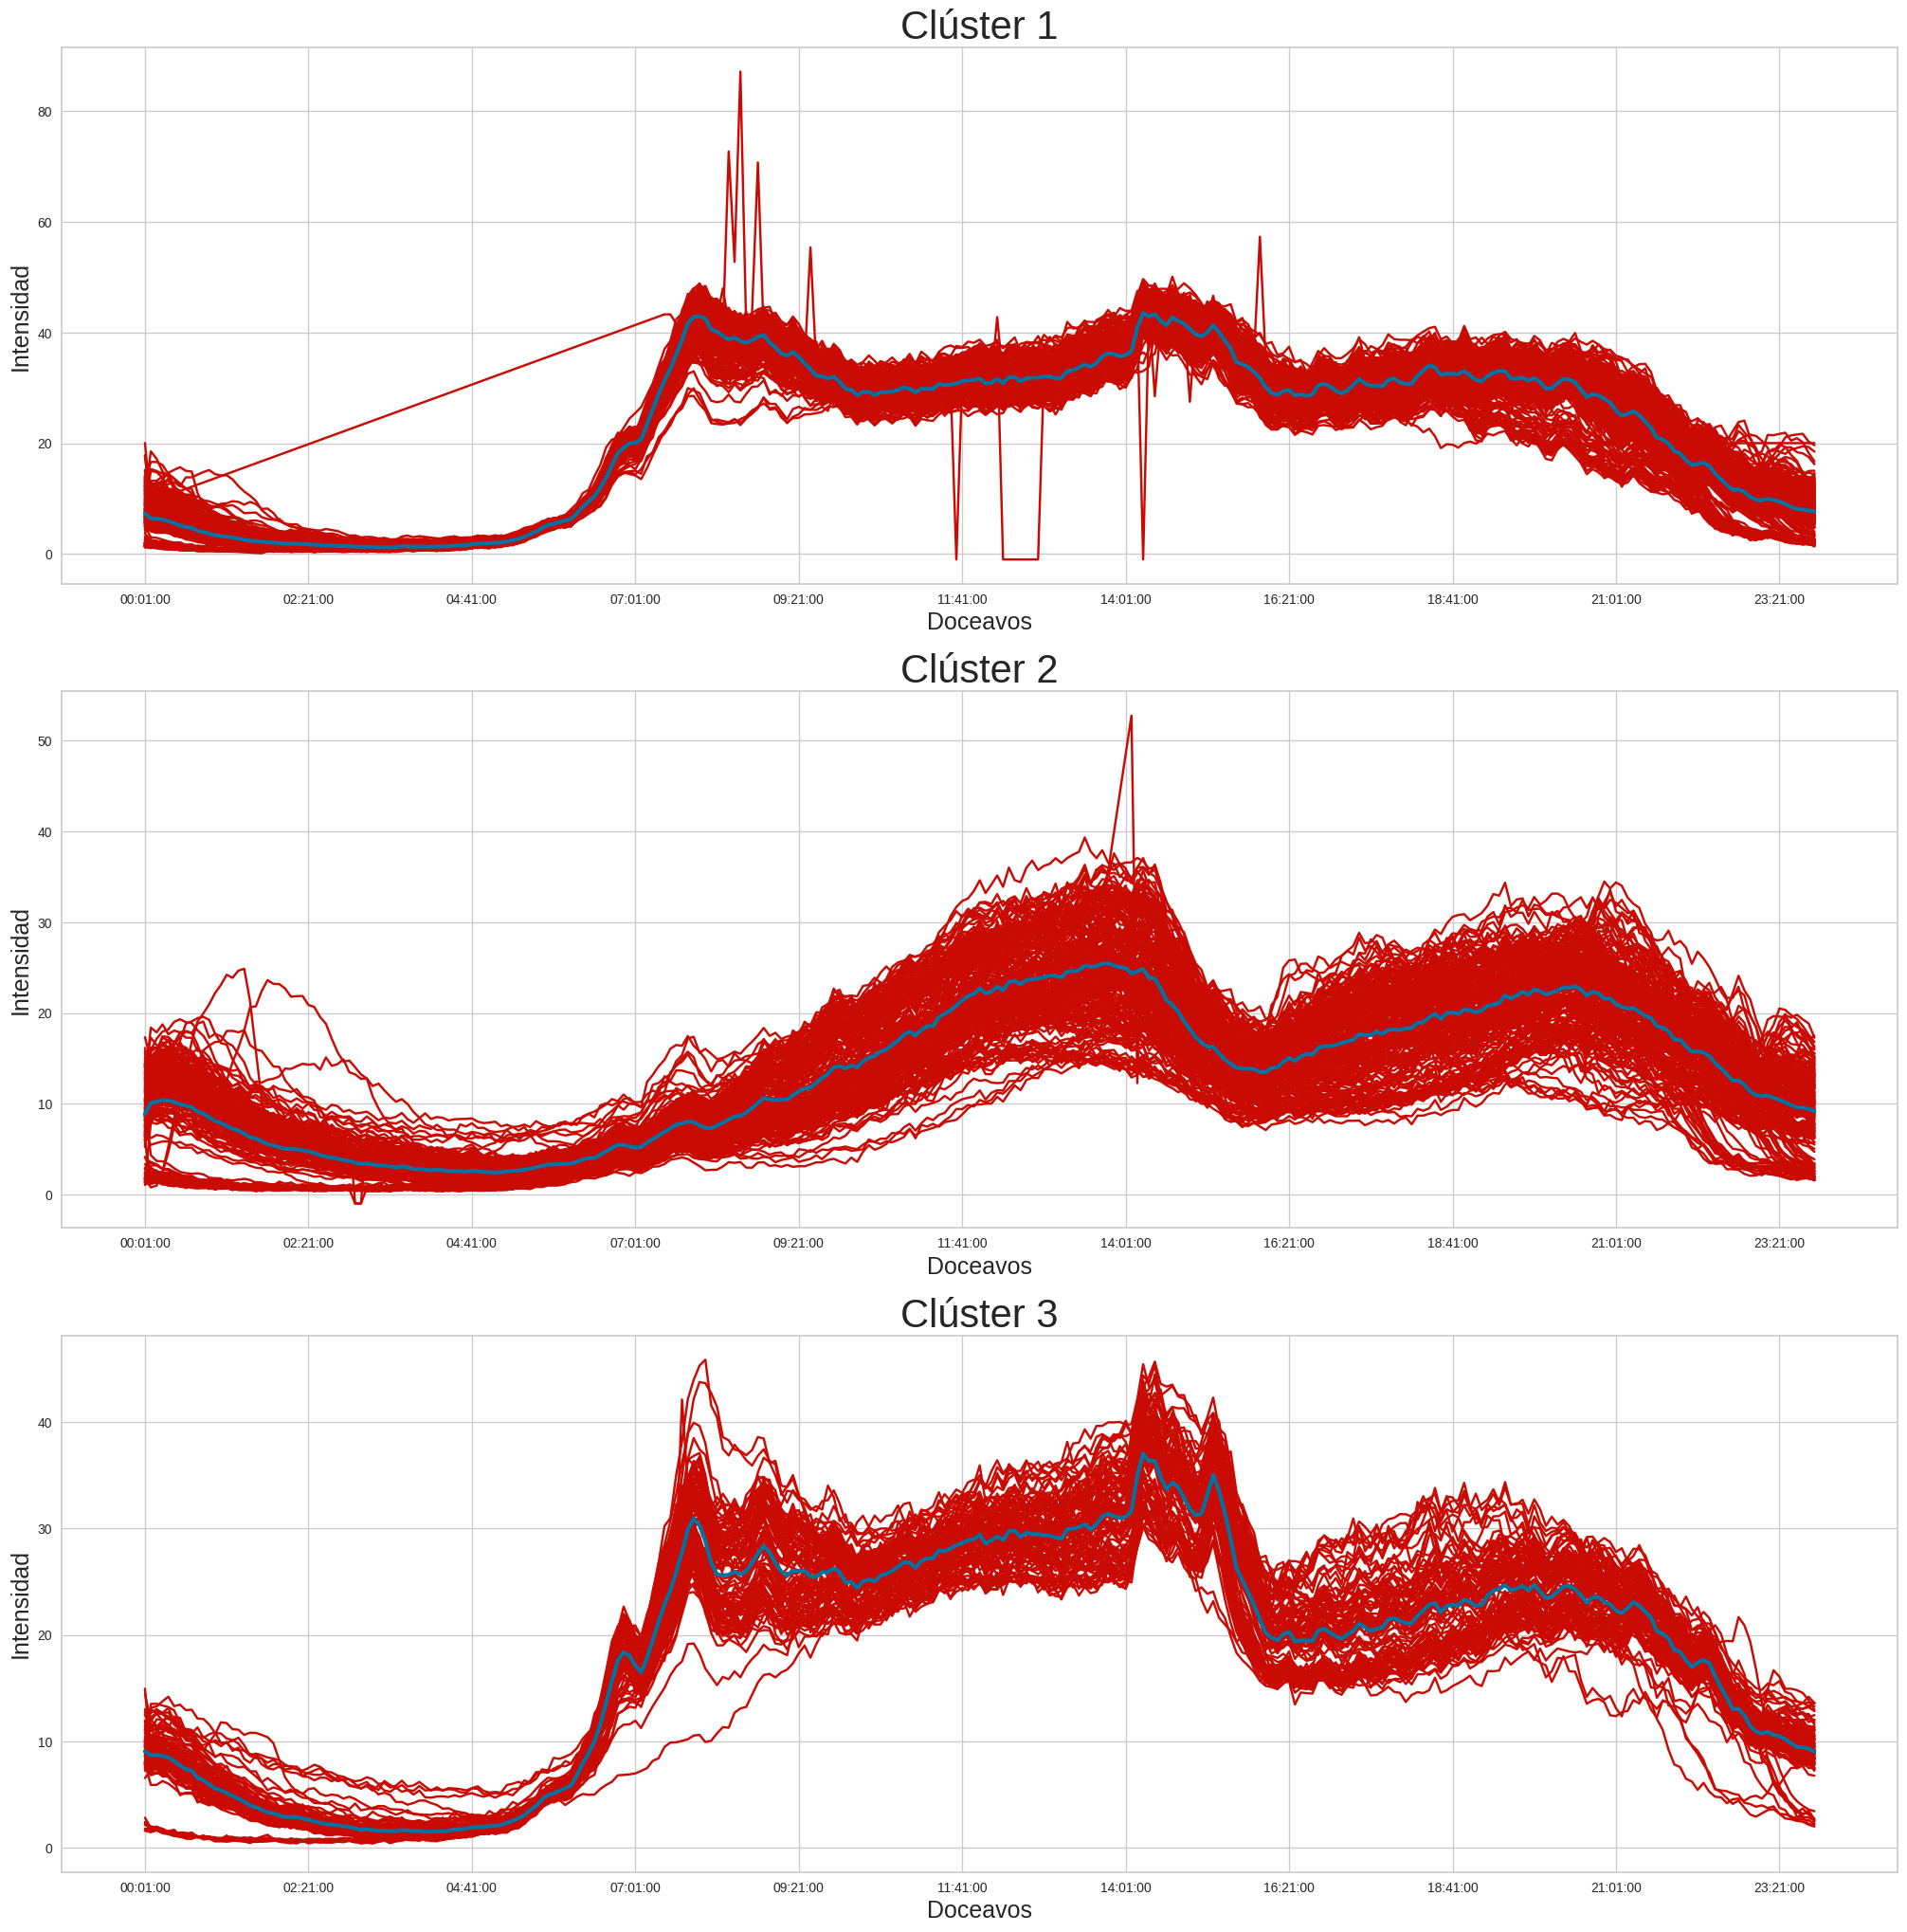

In [51]:

plt.figure(figsize=(8, 4))
plot_data()
plot_centroids()

plt.show()


A continuación se añaden algunas medidas para ayudar a determinar el número óptimo de clústers. En primer lugar calcularemos las intercias para distintos números de clúster. Del 1 al 9.



# Inercias

In [52]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(mySeries)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]
print("======================================================Inercias=========================================================")
print(inertias)

======================================================Inercias=========================================================
[8975780.744710423, 2423399.3551129606, 1850171.653207352, 1507495.3363742768, 1293308.755720004, 1148127.8198171088, 1049326.074656129, 967124.8207086419, 888728.1094794436]


# Método Elbow

Seguidamente, probaremos el método de Elbow, en el que el número óptimo de clústers viene determinado por el punto de inflexión que se genera a partir de la representación de las inercias con los distintos números de clústers.
Es una heurística que consiste en representar gráficamente los valores de las inercias para cada valor de k, y en el valor en el que se observe un punto de inflexión será el número de clústeres óptimo. ¿Qué es la inercia? Es una medida que determina como de bien clasificadas están las series temporales dentro del clúster asignado. Se calcula midiendo la distancia de cada punto al centroide, elevándolo al cuadrado y sumando los cuadrados para un mismo clúster. 

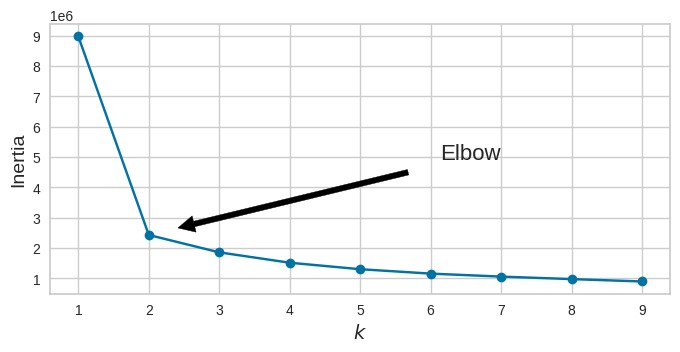

In [53]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(2, inertias[1]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )

plt.show()


Como se observa en la figura superior, el método da un valor de clústers óptimo para k igual a 2. Una clasificación en dos clústers sería muy escasa y no nos permitiría identificar eventos a ciertas horas del día. No podemos pretender que un evento multitudinario afecte a toda la serie temporal y es coherente que siga aceptando una clasificación de dos clústers, pero para este estudio el número debería ser más elevado.

# Coeficiente de la silueta

Otra medida para determinar el número de clústers es el coeficiente de la silueta. A mayor coeficiente mejor opción es. Es la media de los coeficientes de la silueta entre todas las instancias. El coeficiente de la silueta de una instaciase calcula de la siguiente forma:
(𝑏−𝑎)/max(𝑎,𝑏)
Donde 𝑎 es la distancia meda a otras instancias pertenencientes al mismo clúster y 𝑏 es la media de las distancias a las instancias al clúster más cercano. El coeficiente de la silueta puede varias de -1 a +1: si el coeficiente está cercano a +1 quiere decir que la instancia está bien clasificada en su clústery que está lejana al resto de clústers, mientras que si es cercano a 0 quiere decir que está cercano a una frontera de clúster, por último si es cercano a -1 quiere decir que se ha asignado a un clúster erróneo.





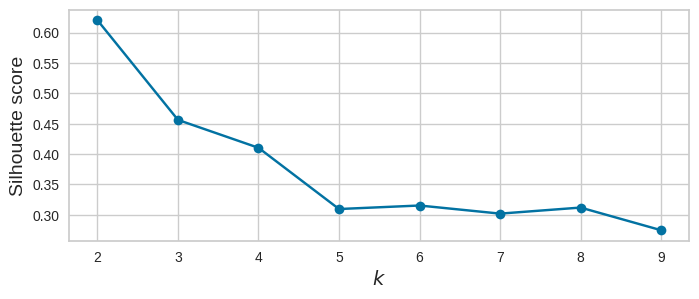

In [54]:
silhouette_scores = [silhouette_score(mySeries, model.labels_)
                     for model in kmeans_per_k[1:]]
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()


Como vemos para nuestro modelo el mayor valor se consigue para 2 clústers.

# Diagrama de la silueta

Otra medida que podemos utilizar es el diagrama de la silueta, a partir de este diagrama podemos ver como de bien están repartidos los clústers y si las instancias llegan al coeficiente de la silueta medio para ese número de clústers o no. El número de clústers óptimo vendrá definido por aquella representación en la que al admitir un aumento en el número de clústers se repartan mejor las instancias y todas lleguen al coeficiente de la silueta medio para esa k.

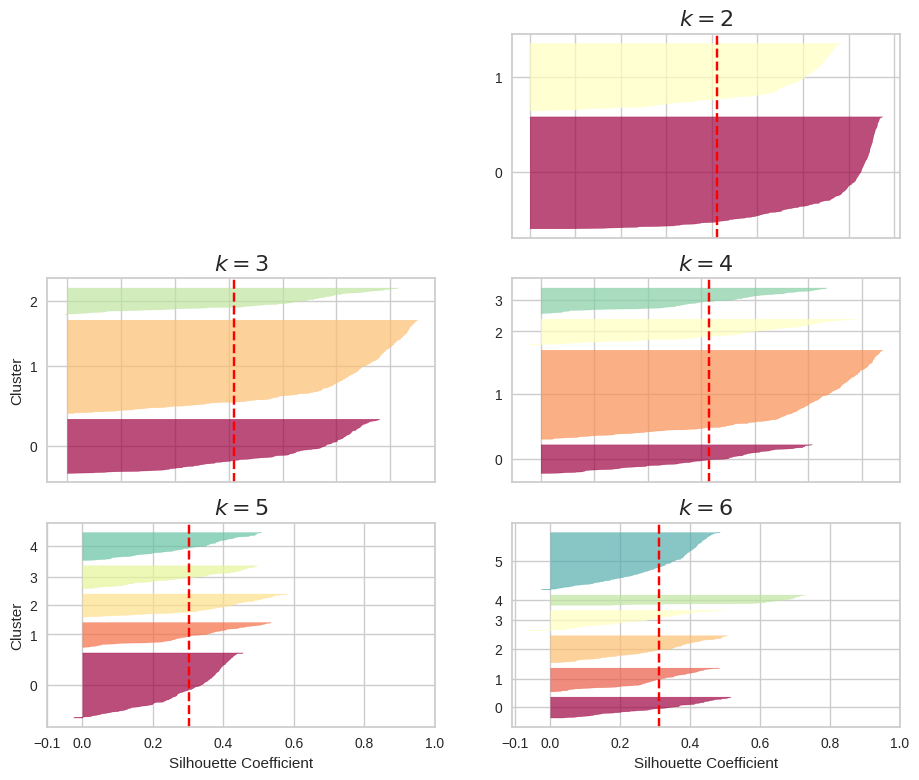

In [55]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (2,3, 4,5,6):
    plt.subplot(3, 2, k )
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(mySeries, y_pred)

    padding = len(mySeries) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

Para esta representación vemos como para todos los número de clústers expuestos las instancias superan el coeficiente de la silueta, para k más pequeñas los conjuntos son muchos más grandes y se ve que admiten más diferenciación.

#Método de Calinski-Harabasz

Como última medida a probar utilizaremos índice de Calinski-Harabasz. El índice Calinski-Harabasz se basa en la comparación de la relación ponderada entre la suma de los cuadrados (la medida de la separación del clúster) y la suma de los cuadrados dentro del clúster (la medida de cómo se empaquetan estrechamente los puntos dentro de un clúster). Idealmente, los clústeres deben estar bien separados, por lo que la suma entre el valor de los cuadrados debe ser grande, pero los puntos dentro de un clúster deben estar lo más cerca posible el uno del otro, dando como resultado valores más pequeños de la suma dentro del clúster de medida de cuadrados. Dado que el índice Calinski-Harabasz es una relación, con la suma de los cuadrados entre el numerador y la suma de cuadrados dentro del denominador, las soluciones de clúster con valores más grandes del índice corresponden a soluciones "mejores" que las soluciones de clúster con valores más pequeños.

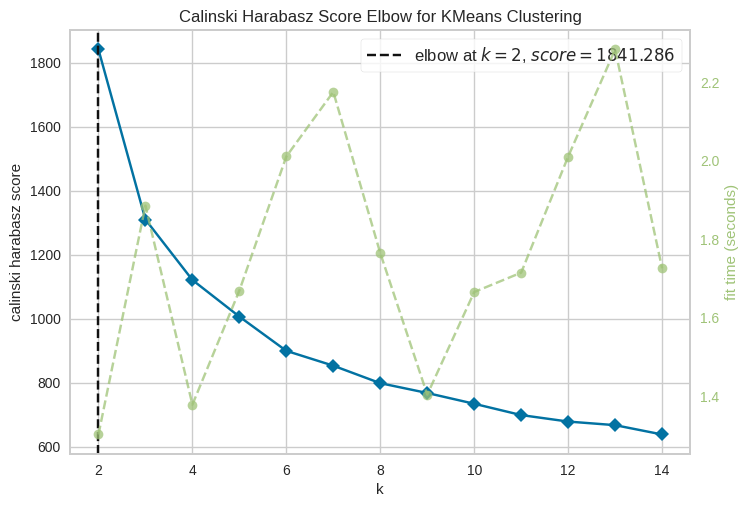

<AxesSubplot: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [56]:
# Calinski Harabasz Score for K means
# Import ElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,15),metric='calinski_harabasz', timings= True)
visualizer.fit(mySeries)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Se obtiene el mayor valor para dos clústers. No obstante, todas estas medidas expuestas sirven para orientarnos, no quiere decir que vaya a ser la solución definitiva. Además, el número de clústers también va a depender de lo que queramos clasificar.

# Clasificación del conjunto de datos

Vamos a recoger una lista los días de la semana que podemos encontrar para cada clúster.


In [59]:
from collections import Counter
dic_dias={}
dic_dates={}

semana=['Lunes','Martes','Miércoles','Jueves','Viernes','Sábado','Domingo']
for m in range(len(mySeries)):
  if y_pred[m] in dic_dias.keys():

    set_c=dic_dias[y_pred[m]]
    date_str=namesofMySeries[m].replace('.csv','').split('intensidad.')  #me quedo con la fecha del nombre

    date=datetime.strptime(date_str[1], "%Y.%m.%d")  #la parseo




    set_c.append(semana[date.weekday()])  #la añado al set
    dic_dias[y_pred[m]]=set_c 
    lis_c=dic_dates[y_pred[m]]
    lis_c.append((date))
    dic_dates[y_pred[m]]=lis_c

  else:
    set_ci=list()

    date_str=namesofMySeries[m].replace('.csv','').split('intensidad.')
    
    date=datetime.strptime(date_str[1], "%Y.%m.%d")

    



    set_ci.append(semana[date.weekday()])
    dic_dias[y_pred[m]]=set_ci

    lis_c=[]
    lis_c.append((date))
    dic_dates[y_pred[m]]=lis_c
final_sem={}
for a,b in dic_dias.items():
  final_sem[a]=Counter(b)



  
print(final_sem)
print(dic_dates[2])

with open(str(currentFile)+'/dias_senalados/dic_dates.pkl', 'wb') as file:
        pickle.dump(dic_dates, file)

{4: Counter({'Viernes': 12, 'Martes': 9, 'Jueves': 8, 'Miércoles': 8, 'Lunes': 7}), 1: Counter({'Sábado': 73, 'Domingo': 19, 'Miércoles': 4, 'Lunes': 3, 'Jueves': 2, 'Martes': 1}), 5: Counter({'Viernes': 55, 'Jueves': 53, 'Miércoles': 52, 'Martes': 45, 'Lunes': 40}), 2: Counter({'Domingo': 79, 'Sábado': 25, 'Lunes': 4, 'Viernes': 3, 'Jueves': 3, 'Miércoles': 1, 'Martes': 1}), 3: Counter({'Martes': 19, 'Lunes': 19, 'Viernes': 17, 'Jueves': 16, 'Miércoles': 15}), 0: Counter({'Lunes': 25, 'Martes': 22, 'Miércoles': 17, 'Jueves': 15, 'Viernes': 11})}
[datetime.datetime(2021, 7, 24, 0, 0), datetime.datetime(2021, 6, 20, 0, 0), datetime.datetime(2022, 5, 22, 0, 0), datetime.datetime(2021, 2, 7, 0, 0), datetime.datetime(2022, 7, 31, 0, 0), datetime.datetime(2021, 11, 21, 0, 0), datetime.datetime(2022, 3, 13, 0, 0), datetime.datetime(2021, 4, 2, 0, 0), datetime.datetime(2021, 12, 25, 0, 0), datetime.datetime(2021, 4, 11, 0, 0), datetime.datetime(2021, 8, 28, 0, 0), datetime.datetime(2022, 8, 2

Como vemos, (depende de la k que utilicemos) pero para valores más altos de k los clústering se especializan en fin de semana. No obstante, hay clústers que integran hasta los 7 dais de la semana contra todo pronóstico, aun siendo un valor alto de k. Hay veces que se engloba en días de tipo fin de semana el lunes y el viernes, esto es debido a que en esos años los puentes cayeron la mayoría en lunes y viernes. Para los casos en los que un clúster engloba todo tipo de días de la semana podemos darle explicación con etapas de vacaciones, la entrada y salida de niños en colegios tiene un impacto importante en estas series temporales y si están de vacaciones esos desplazamientos no se producen.



In [63]:
festivos=['2022-01-01','2022-01-06','2022-02-28','2022-04-14','2022-04-15','2022-05-02','2022-05-04','2022-06-16','2022-08-15','2022-10-12','2022-11-01','2022-12-06',
'2022-12-08','2022-12-26','2021-01-01','2021-01-06','2021-02-28','2021-04-14','2021-04-15','2021-05-02','2021-05-04','2021-06-16','2021-08-15','2021-10-12','2021-11-01','2021-12-06',
'2021-12-08','2021-12-26']
festivos_dates=[]
for f in festivos:
  festivos_dates.append(datetime.strptime(f, "%Y-%m-%d"))
print(festivos_dates)
  
with open(str(currentFile)+'/dias_senalados/festiv.pkl', 'wb') as file:
        pickle.dump(festivos_dates, file)

[datetime.datetime(2022, 1, 1, 0, 0), datetime.datetime(2022, 1, 6, 0, 0), datetime.datetime(2022, 2, 28, 0, 0), datetime.datetime(2022, 4, 14, 0, 0), datetime.datetime(2022, 4, 15, 0, 0), datetime.datetime(2022, 5, 2, 0, 0), datetime.datetime(2022, 5, 4, 0, 0), datetime.datetime(2022, 6, 16, 0, 0), datetime.datetime(2022, 8, 15, 0, 0), datetime.datetime(2022, 10, 12, 0, 0), datetime.datetime(2022, 11, 1, 0, 0), datetime.datetime(2022, 12, 6, 0, 0), datetime.datetime(2022, 12, 8, 0, 0), datetime.datetime(2022, 12, 26, 0, 0), datetime.datetime(2021, 1, 1, 0, 0), datetime.datetime(2021, 1, 6, 0, 0), datetime.datetime(2021, 2, 28, 0, 0), datetime.datetime(2021, 4, 14, 0, 0), datetime.datetime(2021, 4, 15, 0, 0), datetime.datetime(2021, 5, 2, 0, 0), datetime.datetime(2021, 5, 4, 0, 0), datetime.datetime(2021, 6, 16, 0, 0), datetime.datetime(2021, 8, 15, 0, 0), datetime.datetime(2021, 10, 12, 0, 0), datetime.datetime(2021, 11, 1, 0, 0), datetime.datetime(2021, 12, 6, 0, 0), datetime.datetim